# ST451 Bayesian Machine Learning

Candidate number: 54969

Final Project about Bayesian breast cancer classification (Part II)

This file contains the following models:
- A standard neural network not mentioned in the paper but purely used as a benchmark
- A deterministic BNN, containing a probabilistic layer but a deterministic output layer
- A fully probabilistic BNN

Inspiration was gathered from https://keras.io/examples/keras_recipes/bayesian_neural_networks/, where a similar comparison is constructed. Also, https://www.cs.toronto.edu/~duvenaud/distill_bayes_net/public/ is a great source to get a better understanding of BNNs. 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import pandas as pd

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
data = load_breast_cancer()

In [ ]:
X = data.data
y = data.target # 0 = malignant, 1 = benign

In [ ]:
# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

def select_dataset(selection):
    scaler = StandardScaler()          #Instantiate the scaler
    if (selection=="Full"):
        X1 = scaler.fit_transform(X_train[:,0:10] )   #Fit and transform the data
        X2 = scaler.transform(X_test[:,0:10])          #Fit and transform the validation set
    elif (selection=="Sparse"):
        sel=np.array([1,3,9]) #texture, area, symmetry
        X1 = scaler.fit_transform(X_train[:,sel])    #Fit and transform the data
        X2 = scaler.transform(X_test[:,sel] )         #Fit and transform the validation set
    elif (selection=="PCA-based"):
        sel=np.array([0,1,4,5,7,8,9]) #radius, texture, compactness, smoothness, c. points, symmetry and fractal-dim 
        X1 = scaler.fit_transform(X_train[:,sel])    #Fit and transform the data
        X2 = scaler.transform(X_test[:,sel] )         #Fit and transform the validation set
    else:
        print("Choose Full, Sparse or PCA-based")
    return X1,X2

scaled_X_train,scaled_X_test = select_dataset("Full")

# Standard Artificial Neural Network (ANN)

In [ ]:
def basic():
    input_data=tf.keras.Input(shape=(np.shape(scaled_X_train)[1],))
    
    #x= layers.BatchNormalization()(input_data)
    x= layers.Dense(100, activation="relu")(input_data)
    #x= layers.Dense(100, activation="relu")(x)
    output = layers.Dense(1,activation="sigmoid")(x)

    model = keras.models.Model(input_data, output)
    sgd = tf.keras.optimizers.Adam()
    model.compile(optimizer=sgd, loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [ ]:
basic().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 100)               1100      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model=basic()
history=model.fit(scaled_X_train,y_train,epochs=100,verbose=0,validation_data=(scaled_X_test,y_test))

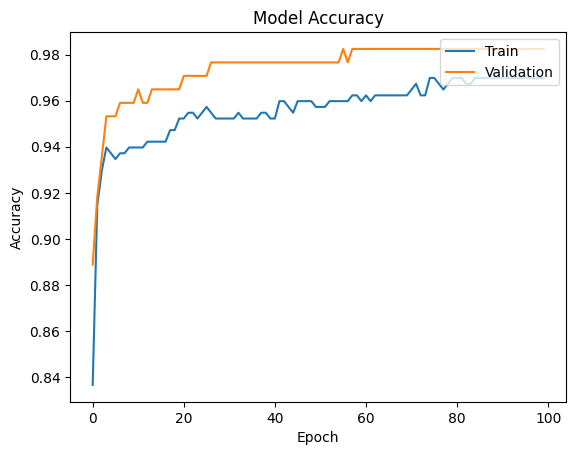

Final validation accuracy 0.9824561476707458
Maximal validation accuracy achieved = 0.9824561476707458 at epoch 56


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print(f"Final validation accuracy", history.history['val_accuracy'][-1])
print(f"Maximal validation accuracy achieved =", np.max(history.history['val_accuracy']), 
      "at epoch",(np.argmax(history.history['val_accuracy'])+1))

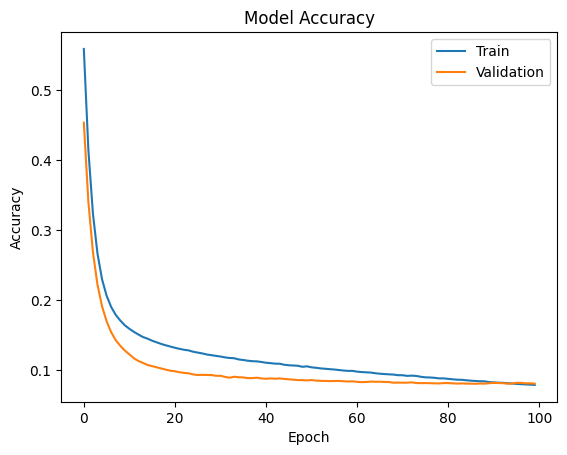

Final validation accuracy 0.9824561476707458
Maximal validation accuracy achieved = 0.9824561476707458 at epoch 56


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print(f"Final validation accuracy", history.history['val_accuracy'][-1])
print(f"Maximal validation accuracy achieved =", np.max(history.history['val_accuracy']), 
      "at epoch",(np.argmax(history.history['val_accuracy'])+1))

# Deterministic Bayesian Neural Network

In [ ]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [ ]:
def BNN():
    input_data=tf.keras.Input(shape=(np.shape(scaled_X_train)[1],))
    
    #x= layers.BatchNormalization()(input_data)
    x= tfp.layers.DenseVariational(
            units=10,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / scaled_X_train.shape[0],
            activation="relu",
        )(input_data)
    #x= tfp.layers.DenseVariational(
    #        units=20,
    #        make_prior_fn=prior,
    #        make_posterior_fn=posterior,
    #        kl_weight=1 / scaled_X_train.shape[0],
    #        activation="relu",
    #    )(x)
    #x= layers.Dense(100, activation="relu")(x)
    output = layers.Dense(1,activation="sigmoid")(x)

    model = keras.models.Model(input_data, output)
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=(['accuracy']))
    return model

In [ ]:
BNN().summary()

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_variational (DenseVar  (None, 10)               6215      
 iational)                                                       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 6,226
Trainable params: 6,226
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model=BNN()
history=model.fit(scaled_X_train,y_train,epochs=500,verbose=0,validation_data=(scaled_X_test,y_test))

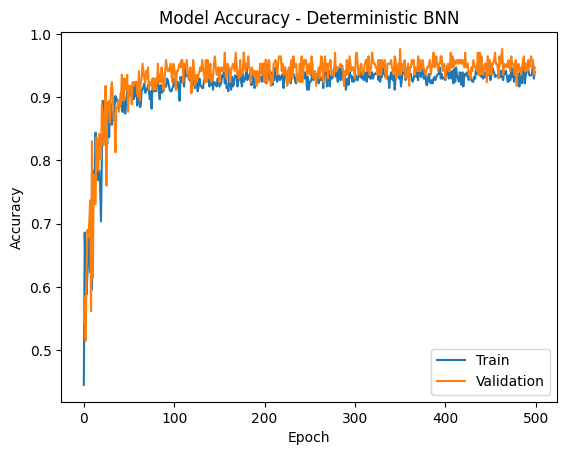

Final validation accuracy 0.9473684430122375
Maximal validation accuracy achieved = 0.9766082167625427 at epoch 351


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Model Accuracy - Deterministic BNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
print(f"Final validation accuracy", history.history['val_accuracy'][-1])
print(f"Maximal validation accuracy achieved =", np.max(history.history['val_accuracy']), 
      "at epoch",(np.argmax(history.history['val_accuracy'])+1))

In [ ]:
print(f"Maximal train accuracy achieved =", np.max(history.history['accuracy']), 
      "at epoch",(np.argmax(history.history['val_accuracy'])+1))

Maximal train accuracy achieved = 0.9572864174842834 at epoch 351


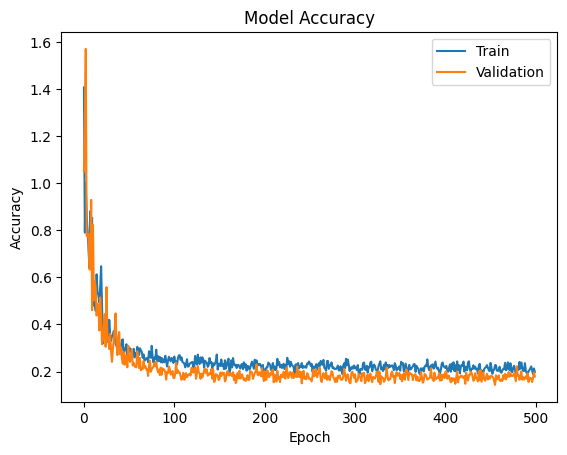

Final validation accuracy 0.9473684430122375
Maximal validation accuracy achieved = 0.9766082167625427 at epoch 351


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print(f"Final validation accuracy", history.history['val_accuracy'][-1])
print(f"Maximal validation accuracy achieved =", np.max(history.history['val_accuracy']), 
      "at epoch",(np.argmax(history.history['val_accuracy'])+1))

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
import seaborn as sns

# Use the trained classifier to make predictions on the train and test set
y_pred_BNN_in_p = model.predict(scaled_X_train)
y_pred_BNN_out_p = model.predict(scaled_X_test)
y_pred_BNN_in = (y_pred_BNN_in_p >= 0.5).astype(int)
y_pred_BNN_out =(y_pred_BNN_out_p >= 0.5).astype(int)

# Calculate the accuracy and F1 score of the classifier
accuracy_BNN_in = accuracy_score(y_train, y_pred_BNN_in)
accuracy_BNN_out = accuracy_score(y_test, y_pred_BNN_out)
f1_BNN_in = f1_score(y_train,y_pred_BNN_in)
f1_BNN_out = f1_score(y_test,y_pred_BNN_out)
print(f"In-sample accuracy: {accuracy_BNN_in}")
print(f"Out-of-sample accuracy: {accuracy_BNN_out}")
print(f"In-sample F1-score: {f1_BNN_in}")
print(f"Out-of-sample F1-score: {f1_BNN_out}")

6/6 [==============================] - 0s 3ms/step
In-sample accuracy: 0.9447236180904522
Out-of-sample accuracy: 0.935672514619883
In-sample F1-score: 0.9563492063492063
Out-of-sample F1-score: 0.9488372093023255


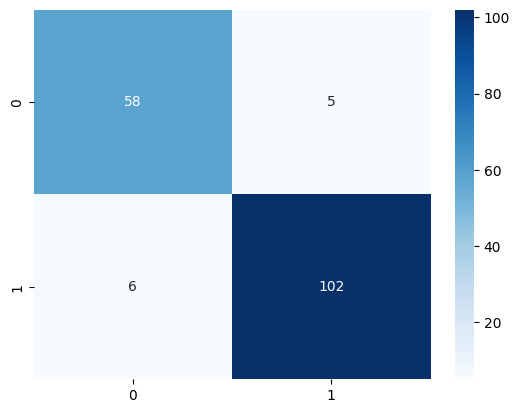

In [ ]:
cm = confusion_matrix(y_test,y_pred_BNN_out)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues");

# Probabilistic Bayesian Neural Network

In [ ]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [ ]:
# binary cross-entropy does not work in this case. Since the a distribution is outputted we want to optimise the negative loglikelihood. 
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [ ]:
def prob_BNN():
    input_data=tf.keras.Input(shape=(np.shape(scaled_X_train)[1],))
    
    #x= layers.BatchNormalization()(input_data)
    x= tfp.layers.DenseVariational(
            units=10,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / X_train.shape[0],
            activation="relu",
        )(input_data)
    # Create a probabilisticå output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
    distribution_params = layers.Dense(units=1)(x)
    outputs = tfp.layers.IndependentBernoulli(1)(distribution_params)

    model = keras.models.Model(input_data, outputs)
    model.compile(optimizer='adam', loss=negative_loglikelihood,metrics=['accuracy'])
    return model

In [ ]:
prob_BNN().summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_variational_2 (DenseV  (None, 10)               6215      
 ariational)                                                     
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
 independent_bernoulli (Inde  ((None, 1),              0         
 pendentBernoulli)            (None, 1))                         
                                                                 
Total params: 6,226
Trainable params: 6,226
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model=prob_BNN()
history=model.fit(scaled_X_train,y_train,epochs=500,verbose=0,validation_data=(scaled_X_test,y_test))

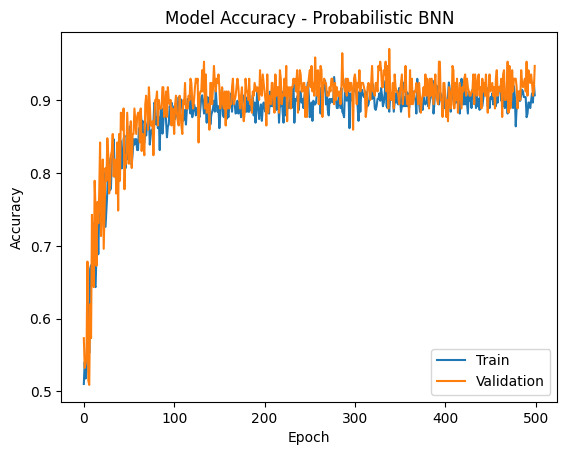

Final validation accuracy 0.9473684430122375
Maximal validation accuracy achieved = 0.9707602262496948 at epoch 339


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Model Accuracy - Probabilistic BNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
print(f"Final validation accuracy", history.history['val_accuracy'][-1])
print(f"Maximal validation accuracy achieved =", np.max(history.history['val_accuracy']), 
      "at epoch",(np.argmax(history.history['val_accuracy'])+1))

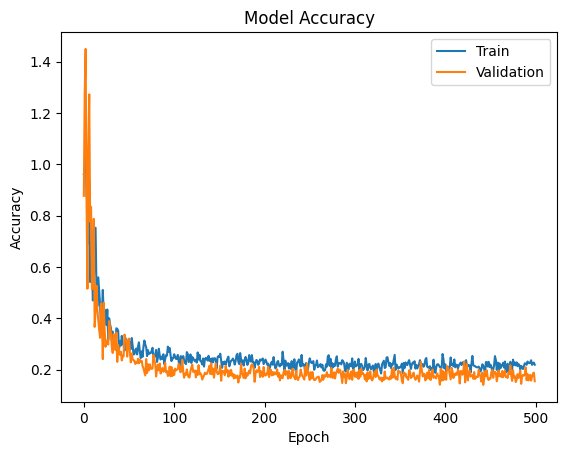

Final validation accuracy 0.9473684430122375
Maximal validation accuracy achieved = 0.9707602262496948 at epoch 339


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print(f"Final validation accuracy", history.history['val_accuracy'][-1])
print(f"Maximal validation accuracy achieved =", np.max(history.history['val_accuracy']), 
      "at epoch",(np.argmax(history.history['val_accuracy'])+1))

In [ ]:
X_tf= tf.convert_to_tensor(scaled_X_test)
y_tf= tf.convert_to_tensor(y_test)
predicted = model(X_tf)
prediction_mean=predicted.mean().numpy().tolist()
prediction_stdv=predicted.stddev().numpy()
upper = (prediction_mean + (1.67 * prediction_stdv)).tolist()
lower = (prediction_mean - (1.67 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()

mu=[]
sig=[]
lowerci=[]
upperci=[]
actual=[]
for idx in range(20):
    mu.append(round(prediction_mean[idx][0], 3))
    sig.append(round(prediction_stdv[idx][0], 3))
    lowerci.append(round(lower[idx][0], 3))
    upperci.append(round(upper[idx][0], 3))
    actual.append(y_tf[idx])

summary = pd.DataFrame(np.array([mu, sig, lowerci, upperci,actual]).T, columns=["Predictive mean","Standard deviation", "Lower","Upper","Actual"])
#print(summary.to_latex())
summary

,Predictive mean,Standard deviation,Lower,Upper,Actual
0,0.873,0.333,0.316,1.429,1.0
1,0.007,0.085,-0.135,0.149,0.0
2,0.003,0.052,-0.084,0.090,0.0
3,0.982,0.132,0.762,1.203,1.0
4,0.999,0.037,0.936,1.061,1.0
5,0.000,0.000,-0.000,0.000,0.0
6,0.000,0.001,-0.001,0.001,0.0
7,0.120,0.324,-0.422,0.661,0.0
8,0.446,0.497,-0.384,1.276,1.0
9,0.995,0.070,0.879,1.112,1.0


In [ ]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
import seaborn as sns

# Use the trained classifier to make predictions on the train and test set
y_pred_pBNN_in_p = model.predict(scaled_X_train)
y_pred_pBNN_out_p = model.predict(scaled_X_test)
y_pred_pBNN_in = (y_pred_pBNN_in_p >= 0.5).astype(int)
y_pred_pBNN_out =(y_pred_pBNN_out_p >= 0.5).astype(int)

# Calculate the accuracy and F1 score of the classifier
accuracy_pBNN_in = accuracy_score(y_train, y_pred_pBNN_in)
accuracy_pBNN_out = accuracy_score(y_test, y_pred_pBNN_out)
f1_pBNN_in = f1_score(y_train,y_pred_pBNN_in)
f1_pBNN_out = f1_score(y_test,y_pred_pBNN_out)
print(f"In-sample accuracy: {accuracy_pBNN_in}")
print(f"Out-of-sample accuracy: {accuracy_pBNN_out}")
print(f"In-sample F1-score: {f1_pBNN_in}")
print(f"Out-of-sample F1-score: {f1_pBNN_out}")

6/6 [==============================] - 0s 3ms/step
In-sample accuracy: 0.8994974874371859
Out-of-sample accuracy: 0.9005847953216374
In-sample F1-score: 0.9196787148594378
Out-of-sample F1-score: 0.9201877934272301


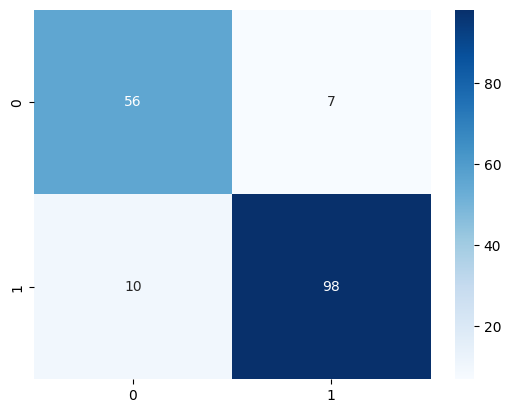

In [ ]:
cm = confusion_matrix(y_test,y_pred_pBNN_out)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues");